In [1]:
import uproot
import awkward as ak
input_tree_md = uproot.open({"/work/guenther/reco_tuner/data/param_data_MD_selected_8520.root": "Selected"})
input_tree_mu = uproot.open({"/work/guenther/reco_tuner/data/param_data_MU_selected_8520.root": "Selected"})
# this is an event list of dictionaries containing awkward arrays
array_md = input_tree_md.arrays()
array_mu = input_tree_mu.arrays()
array = ak.concatenate([array_md, array_mu])
array["dSlope_fringe"] = array["tx_ref"] - array["tx"]
array["z_mag_x_fringe"] = (array["x"] - array["x_ref"] - array["tx"] * array["z"] + array["tx_ref"] * array["z_ref"] ) / array["dSlope_fringe"]
def format_array(name, coef):
    coef = [str(c)+"f" for c in coef if c != 0.0]
    code = f"constexpr std::array {name}"
    code += "{" + ", ".join(list(coef)) +"};"
    return code

<AxesSubplot: >

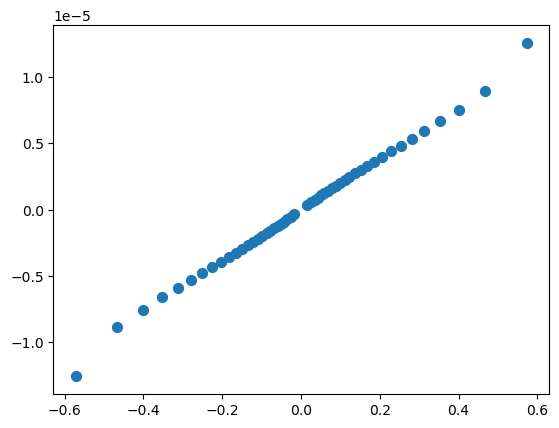

In [2]:
import seaborn as sns
import numpy as np
bins = 50#np.linspace( -1.5, 1.5, 50 )
sns.regplot(x=ak.to_numpy(array["dSlope_fringe"]), y=ak.to_numpy(array["CX_ex"]), x_bins=bins, fit_reg=None, x_estimator=np.mean)

<AxesSubplot: >

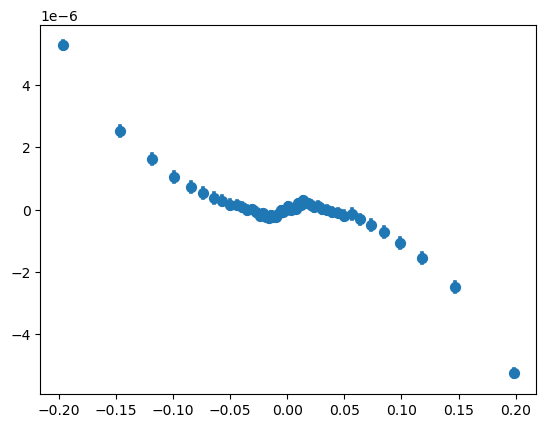

In [3]:
bins = 50#np.linspace( -1., 1., 50 )
sns.regplot(x=ak.to_numpy(array["tx"]), y=ak.to_numpy(array["CX_ex"]), x_bins=bins, fit_reg=None, x_estimator=np.mean)

<AxesSubplot: >

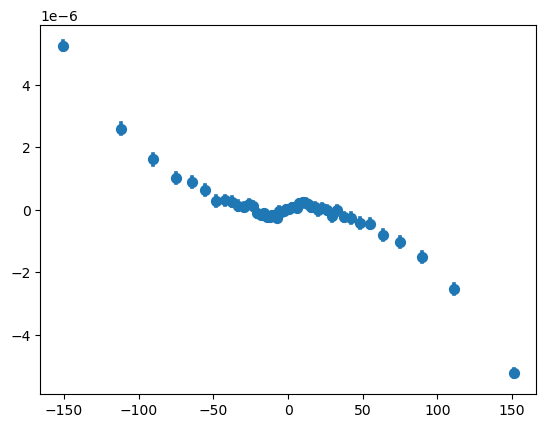

In [4]:
bins = 50#np.linspace( -1., 1., 50 )
sns.regplot(x=ak.to_numpy(array["x"]), y=ak.to_numpy(array["CX"]), x_bins=bins, fit_reg=None, x_estimator=np.mean)

<AxesSubplot: >

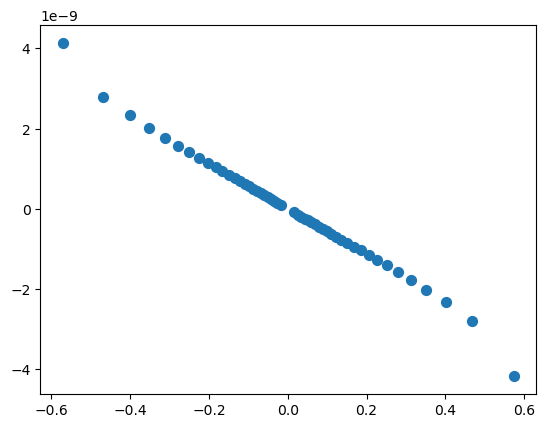

In [5]:
bins = 50#np.linspace( -1., 1., 50 )
sns.regplot(x=ak.to_numpy(array["dSlope_fringe"]), y=ak.to_numpy(array["DX"]), x_bins=bins, fit_reg=None, x_estimator=np.mean)

<AxesSubplot: >

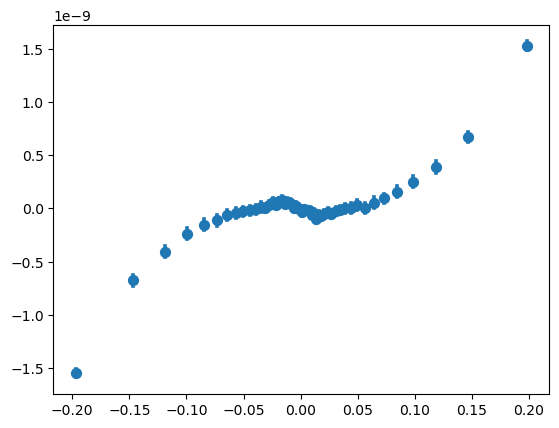

In [6]:
bins = 50#np.linspace( -1., 1., 50 )
sns.regplot(x=ak.to_numpy(array["tx"]), y=ak.to_numpy(array["DX"]), x_bins=bins, fit_reg=None, x_estimator=np.mean)

<AxesSubplot: >

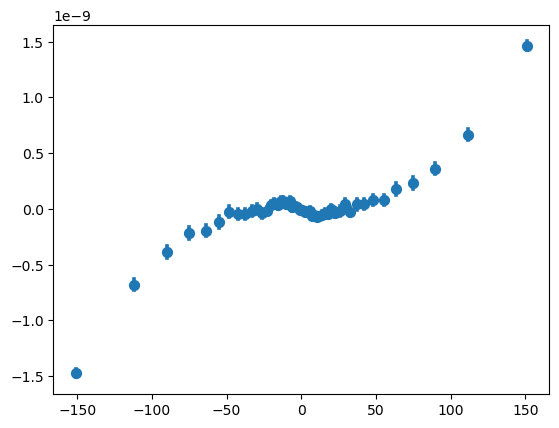

In [7]:
bins = 50#np.linspace( -1., 1., 50 )
sns.regplot(x=ak.to_numpy(array["x"]), y=ak.to_numpy(array["DX"]), x_bins=bins, fit_reg=None, x_estimator=np.mean)

In [8]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

features = [
    "tx", 
    "ty",
    "dSlope_fringe",
]
target_feat = "CX_ex"

data = np.column_stack([ak.to_numpy(array[feat]) for feat in features])
target = ak.to_numpy(array[target_feat])
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

poly = PolynomialFeatures(degree=3, include_bias=False)
X_train_model = poly.fit_transform( X_train ) 
X_test_model = poly.fit_transform( X_test ) 

poly_features = poly.get_feature_names_out(input_features=features)
remove = [i for i, f in enumerate(poly_features) if ("dSlope_fringe" not in f ) or ("dSlope_fringe^" in f)]
X_train_model = np.delete( X_train_model, remove, axis=1)
X_test_model = np.delete( X_test_model, remove, axis=1)
poly_features = np.delete(poly_features, remove )
print(poly_features)

lin_reg = LinearRegression(fit_intercept=False)
lin_reg.fit( X_train_model, y_train)
y_pred_test = lin_reg.predict( X_test_model )
print("intercept=", lin_reg.intercept_)
print("coef=", dict(zip(poly_features, lin_reg.coef_)))
print("r2 score=", lin_reg.score(X_test_model, y_test))
print("RMSE =", mean_squared_error(y_test, y_pred_test, squared=False))
print(format_array("cx_params", lin_reg.coef_))

['dSlope_fringe' 'tx dSlope_fringe' 'ty dSlope_fringe'
 'tx^2 dSlope_fringe' 'tx ty dSlope_fringe' 'ty^2 dSlope_fringe']
intercept= 0.0
coef= {'dSlope_fringe': 2.3340814100448438e-05, 'tx dSlope_fringe': 8.310801914170572e-09, 'ty dSlope_fringe': -1.025087641029144e-06, 'tx^2 dSlope_fringe': 8.228862899700043e-06, 'tx ty dSlope_fringe': -1.5662848683486495e-06, 'ty^2 dSlope_fringe': -0.0003728935994887431}
r2 score= 0.9860788549938552
RMSE = 6.07178841864582e-07
constexpr std::array cx_params{2.3340814100448438e-05f, 8.310801914170572e-09f, -1.025087641029144e-06f, 8.228862899700043e-06f, -1.5662848683486495e-06f, -0.0003728935994887431f};


In [9]:
features = [
    "tx", 
    "ty",
    "dSlope_fringe",
]
target_feat = "DX_ex"

data = np.column_stack([ak.to_numpy(array[feat]) for feat in features])
target = ak.to_numpy(array[target_feat])
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

poly = PolynomialFeatures(degree=3, include_bias=False)
X_train_model = poly.fit_transform( X_train ) 
X_test_model = poly.fit_transform( X_test ) 

poly_features = poly.get_feature_names_out(input_features=features)
remove = [i for i, f in enumerate(poly_features) if ("dSlope_fringe" not in f ) or ("dSlope_fringe^" in f)]
X_train_model = np.delete( X_train_model, remove, axis=1)
X_test_model = np.delete( X_test_model, remove, axis=1)
poly_features = np.delete(poly_features, remove )
print(poly_features)

lin_reg = LinearRegression(fit_intercept=False)
lin_reg.fit( X_train_model, y_train)
y_pred_test = lin_reg.predict( X_test_model )
print("intercept=", lin_reg.intercept_)
print("coef=", dict(zip(poly_features,lin_reg.coef_)))
print("r2 score=", lin_reg.score(X_test_model, y_test))
print("RMSE =", mean_squared_error(y_test, y_pred_test, squared=False))
print(format_array("dx_params", lin_reg.coef_))

['dSlope_fringe' 'tx dSlope_fringe' 'ty dSlope_fringe'
 'tx^2 dSlope_fringe' 'tx ty dSlope_fringe' 'ty^2 dSlope_fringe']
intercept= 0.0
coef= {'dSlope_fringe': -7.054315710920644e-09, 'tx dSlope_fringe': 2.22196526392023e-11, 'ty dSlope_fringe': 6.104698063377923e-10, 'tx^2 dSlope_fringe': 2.85681046841909e-09, 'tx ty dSlope_fringe': 3.789175266592706e-10, 'ty^2 dSlope_fringe': 9.907774160587578e-08}
r2 score= 0.97610245571401
RMSE = 2.4251033068807623e-10
constexpr std::array dx_params{-7.054315710920644e-09f, 2.22196526392023e-11f, 6.104698063377923e-10f, 2.85681046841909e-09f, 3.789175266592706e-10f, 9.907774160587578e-08f};
